<a href="https://colab.research.google.com/github/dine1717/EVA6/blob/Session5/Step_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/ERA2/Session7/models')

In [4]:
# Auto reload the modules
%load_ext autoreload
%autoreload 2

In [5]:
from model import Model_4

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split


In [7]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 159135996.25it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105980484.54it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44515836.95it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15968590.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


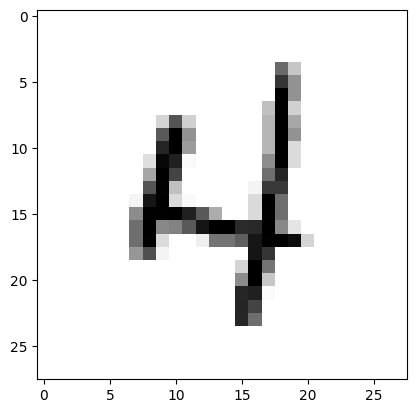

In [9]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already


dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

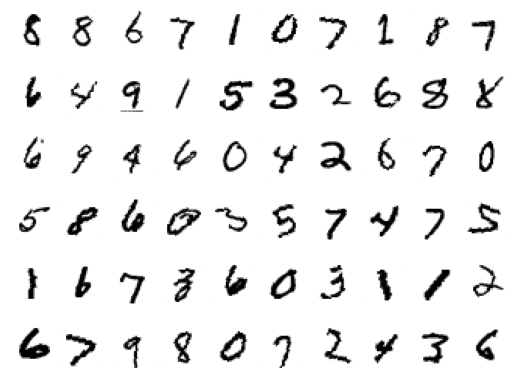

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [11]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_4().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
       BatchNorm2d-2           [-1, 12, 28, 28]              24
              ReLU-3           [-1, 12, 28, 28]               0
           Dropout-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,296
       BatchNorm2d-6           [-1, 12, 28, 28]              24
              ReLU-7           [-1, 12, 28, 28]               0
           Dropout-8           [-1, 12, 28, 28]               0
         MaxPool2d-9           [-1, 12, 14, 14]               0
           Conv2d-10           [-1, 12, 12, 12]           1,296
      BatchNorm2d-11           [-1, 12, 12, 12]              24
             ReLU-12           [-1, 12, 12, 12]               0
          Dropout-13           [-1, 12, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.1206677183508873 Batch_id=468 Accuracy=82.94: 100%|██████████| 469/469 [00:23<00:00, 20.23it/s]



Test set: Average loss: 0.0702, Accuracy: 9844/10000 (98.44%)

EPOCH: 1


Loss=0.22011077404022217 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]



Test set: Average loss: 0.0444, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.05540350079536438 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]



Test set: Average loss: 0.0361, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.0746719017624855 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:23<00:00, 19.78it/s]



Test set: Average loss: 0.0266, Accuracy: 9920/10000 (99.20%)

EPOCH: 4


Loss=0.12459344416856766 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.0265, Accuracy: 9929/10000 (99.29%)

EPOCH: 5


Loss=0.02063186839222908 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0248, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.06308824568986893 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:23<00:00, 19.83it/s]



Test set: Average loss: 0.0239, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.12548109889030457 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]



Test set: Average loss: 0.0247, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.006661698222160339 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]



Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.052959173917770386 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]



Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.04659676179289818 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:21<00:00, 21.35it/s]



Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.008048984222114086 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]



Test set: Average loss: 0.0209, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.06775439530611038 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]



Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.046459171921014786 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]



Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.02116444520652294 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]



Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

